# Bigger, Better, Faster or Rainbow DQN v2
### by: Mateusz Doliński, Mateusz Olko
### special thanks for the inspiration: Michał Nauman

In this homework we will expand upon on the Deep Q-Network (DQN) algorithm [(Mnih 2014)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). DQN has been successfully applied to a wide range of environments and has demonstrated strong performance on many tasks. However, several challenges and limitations to the DQN that have been identified in the literature:

1. Sample complexity - DQN can require a large number of samples to learn effectively, especially in environments with high-dimensional state spaces or a large number of possible actions
2. Convergence - DQN is known to converge to the optimal solution under certain conditions, but the convergence properties of the algorithm are not well understood and it is not guaranteed to converge in all cases
3. Overestimation - DQN is known to sometimes overestimate the Q-values of certain actions, which can lead to suboptimal behavior
4. Sensitivity to hyperparameters - DQN can be sensitive to the choice of hyperparameters, such as the learning rate, the discount factor, and the exploration scheme.

Last year the task was to implement the rainbow algorithm [(Hessel 2017)](https://arxiv.org/pdf/1710.02298.pdf). The algorithm is a combination of several techniques for improving the performance of the DQN algorithm, which was originally proposed by DeepMind. Rainbow algorithm is able to improve the sample efficiency, stability and  performance of the DQN algorithm. The improvements include u.a.:

1. Double DQN
2. N-step Q-value estimation
3. Noisy Layer exploration
4. Dueling DQN
5. Prioritized experience replay

Reinforcement Learning is still a new branch of research and paradigms tend to raise and fall quite frequently. In this case, the recent literature proved that the last 3 improvementx of rainbow DQN are not as good as advertised. In their place [(Schwarzer et al. 2023)](https://arxiv.org/pdf/2305.19452.pdf) introduced other improvements that add up to the new Bigger, Better, Faster (BBF) algorithm.

In this homework, you will augment a baseline DQN implementation with components of BBF except for distributional Q-learning. To test our implementations, we will use the Lunar Lander environment with a budget of 40000 enironment steps and 30000 Q-network weight updates. You will also implement the evaluation as in [(Agarwal et al. 2022)](https://arxiv.org/pdf/2108.13264.pdf).

## Homework scenario and grading

You are provided with a baseline implementation of the DQN. Your job is to expand it with the following modules:

1. N-step Q-value estimation with horizon annealing **2 points**
2. Discount annealing **1 point**
3. Q-network resets **2 points**
4. BBF **2 points**
5. IQM evaluation **3 points**

In [13]:
! pip install swig
! pip install 'gymnasium[box2d]>=0.29.0'
! pip install typeguard==2.13.3
! pip install torchtyping


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pygame-2.5.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (13 kB)
Using cached pygame-2.5.2-cp311-cp311-macosx_11_0_arm64.whl (12.2 MB)
  error: subprocess-exited-with-error
  
  × Building wheel for box2d-py (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      Using setuptools (version 69.0.3).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-13-arm64-cpython-311
      creating build/lib.macosx-13-arm64-cpython-311/Box2D
      copying library/Box2D/Box2D.py -> build/lib.macosx-13-arm64-cpython-311/Box2D
      copying library/Box2D/__init__.py -> build/lib.macosx-13-arm64-c

In [1]:
import time
from collections import deque
from dataclasses import dataclass, field
from functools import cached_property
from typing import Any, Callable

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchtyping import TensorType

You are given a simple class for holding the hyperparameters (do not change those!) and a helper functions for setting seeds and orthogonal weight initialization.

In [2]:
# do NOT change!
@dataclass(frozen=True)
class Hyperparameters:
    capacity: int = 10000
    init_steps: int = 10000
    total_timesteps = 40000
    batch_size: int = 128
    hidden_dim: int = 128
    optimizer_params: dict[str, Any] = field(
        default_factory=lambda: {
            "lr": 7e-4,
            "eps": 1e-5,
            "weight_decay": 1e-3,
        }
    )
    samples: int = 3
    target_update_freq: int = 50
    evaluate_freq: int = 1000
    evaluate_samples: int = 5

    anneal_steps: int = 30000

    init_discount: float = 0.8
    final_discount: float = 0.99

    init_epsilon: float = 0.1
    final_epsilon: float = 0.05

    init_nstep: int = 10
    final_nstep: int = 3
    anneal_nstep_freq: int = 2000

    reset_freq: int = 30100
    replay_ratio: int = 2

    gym_id: str = "LunarLander-v2"
    cuda: bool = True

    @cached_property
    def state_dim(self) -> int:
        env = gym.make(self.gym_id)
        return env.observation_space.shape[0]

    @cached_property
    def action_dim(self) -> int:
        env = gym.make(self.gym_id)
        return env.action_space.n

    @cached_property
    def device(self) -> torch.device:
        return torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")


hyperparameters = Hyperparameters()

In [3]:
def set_seed_everywhere(
    env: gym.wrappers.time_limit.TimeLimit,
    seed: int,
) -> None:
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.reset(seed=seed)


def weight_init(model: nn.Module) -> None:
    if isinstance(model, nn.Linear):
        nn.init.orthogonal_(model.weight.data)
        model.bias.data.fill_(0.0)

## 0. Baseline DQN

Deep Q-Network (DQN) [(Mnih 2014)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a reinforcement learning algorithm that uses a deep neural network to learn a Q-function, which is a function that estimates the expected return for taking a given action in a given state. The goal of the DQN algorithm is to learn a policy that maximizes the expected return by learning the Q-function and selecting the action with the highest estimated return in each state.

The DQN algorithm consists of two main components: a Q-network and an experience buffer. The Q-network is a deep neural network that takes in a state as input and outputs the estimated Q-values for each possible action. The experience buffer is a data structure that stores a set of experiences. The DQN algorithm works by interacting with the environment and storing the experiences in the experience buffer. The Q-network is then trained using a mini-batch of experiences uniformly sampled from the experience buffer. This process is known as experience replay and is used to decorrelate the experiences and to stabilize the learning process. The Q-network is updated using the loss function:

$$
\mathcal{L}_{\theta} = \frac{1}{B} \sum_{i=1}^{B} \bigl( \mathrm{TD}~(s_i, a_i, s^{'}_{i}) \bigr)^{2}
$$

With:

$$
\mathrm{TD}~(s_i, a_i, s^{'}_{i}) = Q_{\theta}~(s_i,a_i) - \bigl(r_{(s_i,a_i,s_{i}^{'})} + \gamma ~ \underset{a^{'}_{i} \sim \bar{Q}_{\theta}}{\mathrm{max}} ~ \bar{Q}_{\theta}~(s_{i}^{'},a_{i}^{'}) \bigr)
$$

Where $Q_{\theta}$ and $\bar{Q}_{\theta}$ denote learned and target Q-networks respectively. The target network is a copy of the Q-network that is updated less frequently, and using it to compute the target Q-values helps to stabilize the learning process and improve the performance of the DQN algorithm. Note that to increase stability of training we use Huber loss (smooth_l1_loss) instead of L2.

There are several ways to incorporate exploration into the DQN algorithm. One common method is to use an $\epsilon$-greedy exploration strategy, where the agent takes a random action with probability $\epsilon$ and takes the action with the highest estimated Q-value with probability $1 - \epsilon$. The value of $\epsilon$ is typically decreased over time, so that the agent initially explores more and then gradually shifts towards exploitation as it learns more about the environment.

Below, you will find the implementaiton of all the components of a basic DQN:

**Experience buffer** - a data structure that stores a set of transitions, where a transition is typically represented as a tuple $(s, a, r, s', t)$, where $s$ is the state, $a$ is the action taken in state $s$, $r$ is the reward received by performing $a$ in $s$ and getting to $s'$, $s'$ is the new state observed after performing $a$ in $s$ and $t$ is the termination boolean (true if $s'$ is terminal). The **ExperienceBuffer** class below is using NumPy arrays has two methods:

1. *add* - adds transition to the buffer
2. *sample* - samples a batch of transitions from the buffer

In [4]:
class ExperienceBuffer:
    def __init__(
        self,
        hyperparameters: Hyperparameters,
    ) -> None:
        self.states = np.zeros((hyperparameters.capacity, hyperparameters.state_dim), dtype=np.float32)
        self.actions = np.zeros((hyperparameters.capacity, 1), dtype=np.int64)
        self.rewards = np.zeros((hyperparameters.capacity, 1), dtype=np.float32)
        self.next_states = np.zeros((hyperparameters.capacity, hyperparameters.state_dim), dtype=np.float32)
        self.terminals = np.zeros((hyperparameters.capacity, 1), dtype=np.int64)
        self.full = False
        self.idx = 0
        self.hyperparameters = hyperparameters

    def add(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        terminal: bool,
    ) -> None:
        self.states[self.idx, :] = state
        self.actions[self.idx, :] = action
        self.rewards[self.idx, :] = reward
        self.next_states[self.idx, :] = next_state
        self.terminals[self.idx, :] = 1 if terminal else 0
        self.idx += 1
        if self.idx == self.hyperparameters.capacity:
            self.full = True
            self.idx = 0

    def sample(
        self,
    ) -> tuple[
        TensorType["batch", "state_dim"],
        TensorType["batch", 1],
        TensorType["batch", 1],
        TensorType["batch", "state_dim"],
        TensorType["batch", 1],
    ]:
        idx = (
            np.random.permutation(self.hyperparameters.capacity)[: self.hyperparameters.batch_size]
            if self.full
            else np.random.permutation(self.idx - 1)[: self.hyperparameters.batch_size]
        )
        states = torch.from_numpy(self.states[idx]).to(self.hyperparameters.device)
        actions = torch.from_numpy(self.actions[idx]).to(self.hyperparameters.device)
        rewards = torch.from_numpy(self.rewards[idx]).to(self.hyperparameters.device)
        next_states = torch.from_numpy(self.next_states[idx]).to(self.hyperparameters.device)
        terminals = torch.from_numpy(self.terminals[idx]).long().to(self.hyperparameters.device)
        return states, actions, rewards, next_states, terminals


**QNetwork** - a simple dense MLP. Note the output size being equal to the amount of actions in the environment.

In [5]:
class QNetwork(nn.Module):
    def __init__(
            self,
            hyperparameters: Hyperparameters,
        ) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(hyperparameters.state_dim, hyperparameters.hidden_dim),
            nn.ReLU(),
            nn.Linear(hyperparameters.hidden_dim, hyperparameters.hidden_dim),
            nn.ReLU(),
            nn.Linear(hyperparameters.hidden_dim, hyperparameters.action_dim),
        )
        self.apply(weight_init)

    def forward(
            self,
            x: TensorType["batch", "state_dim"],
        ) -> TensorType["batch", "actions_dim"]:
        return self.layers(x)

**DQN agent** - implementation of the callbacks required to learn the DQN algorithm. The class has following methods:

1. *get_action* - returns action in given state using $\epsilon$-greedy
2. *anneal* - reduces the value of $\epsilon$ dependent on the training step
3. *update* - samples a batch of transitions from the experience buffer and performs a DQN update
4. *update_target* - performs a hard update on the target Q network $\bar{Q}_{\theta}$
5. *evaluate* - performs evaluation of the agent with a greedy policy
6. *reset* - resets the agent (used between seeds)

In [6]:
class DQNBaseline:
    def __init__(
        self,
        hyperparameters: Hyperparameters,
    ) -> None:
        self.hyperparameters = hyperparameters
        self.buffer = ExperienceBuffer(self.hyperparameters)
        self.q_net = QNetwork(self.hyperparameters).to(self.hyperparameters.device)
        self.q_target = QNetwork(self.hyperparameters).to(self.hyperparameters.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), **self.hyperparameters.optimizer_params)

        self.epsilon = self.hyperparameters.init_epsilon
        self.discount = self.hyperparameters.final_discount

    def reset(self) -> None:
        self.buffer = ExperienceBuffer(self.hyperparameters)
        self.epsilon = self.hyperparameters.init_epsilon
        self.q_net = QNetwork(self.hyperparameters).to(self.hyperparameters.device)
        self.q_target = QNetwork(self.hyperparameters).to(self.hyperparameters.device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), **self.hyperparameters.optimizer_params)

    def get_action(
        self,
        state: np.ndarray,
        exploration: bool = True,
    ) -> int:
        with torch.no_grad():
            return (
                np.random.randint(self.hyperparameters.action_dim)
                if np.random.sample() < self.epsilon and exploration
                else torch.argmax(self.q_net(state)).item()
            )

    def anneal(
        self,
        step: int,
    ) -> None:
        self.epsilon = (
            ((self.hyperparameters.final_epsilon - self.hyperparameters.init_epsilon) / self.hyperparameters.anneal_steps) * step
            + self.hyperparameters.init_epsilon
            if step < self.hyperparameters.anneal_steps
            else self.epsilon
        )

    def update(self) -> None:
        states, actions, rewards, next_states, terminals = self.buffer.sample()
        with torch.no_grad():
            q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
        q_targets = rewards + (1 - terminals) * self.discount * q_ns

        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets)
        loss.backward()
        self.optimizer.step()

    def update_target(self) -> None:
        self.q_target.load_state_dict(self.q_net.state_dict())

    def evaluate(
        self,
        samples: int,
    ) -> np.ndarray:
        with torch.no_grad():
            env_test = gym.make(self.hyperparameters.gym_id, max_episode_steps=1000)
            eval_rewards = np.zeros((samples,))
            for i in range(samples):
                state, _ = env_test.reset()
                episode_reward = 0
                while True:
                    action = self.get_action(torch.tensor(state).unsqueeze(0).to(self.hyperparameters.device), False)
                    next_state, reward, terminal, truncated, _ = env_test.step(action)
                    episode_reward += reward
                    state = next_state
                    if terminal or truncated:
                        # eval_reward += episode_reward / samples
                        eval_rewards[i] = episode_reward
                        break
        return eval_rewards


Finally, you are presented with the training loop for the DQN agents (do NOT change this):

In [7]:
def train_agent(
    hyperparameters: Hyperparameters,
    agent: DQNBaseline,
) -> np.ndarray:
    results = np.zeros(
        (
            hyperparameters.total_timesteps // hyperparameters.evaluate_freq,
            hyperparameters.samples,
            hyperparameters.evaluate_samples
        )
    )
    for seed_idx, seed in enumerate(range(hyperparameters.samples)):
        env = gym.make(hyperparameters.gym_id, max_episode_steps=1000)
        agent.reset()
        set_seed_everywhere(env, seed)
        state, _ = env.reset()
        for step in range(hyperparameters.total_timesteps):
            if step == hyperparameters.init_steps:
                start_time = time.time()
            action = agent.get_action(
                torch.tensor(state).unsqueeze(0).to(hyperparameters.device)
            )
            next_state, reward, terminal, truncated, _ = env.step(action)
            agent.buffer.add(state, action, reward, next_state, terminal or truncated)
            agent.anneal(step)
            state = next_state
            if step >= hyperparameters.init_steps:
                for update_num in range(hyperparameters.replay_ratio):
                    agent.update()
                    if (
                        step * hyperparameters.replay_ratio + update_num + 1
                    ) % hyperparameters.target_update_freq == 0:
                        agent.update_target()
                if (step + 1) % hyperparameters.evaluate_freq == 0:
                    eval_rewards = agent.evaluate(hyperparameters.evaluate_samples)
                    results[step // hyperparameters.evaluate_freq, seed] = eval_rewards
                    print(
                        "\rSample number: {} Step: {} Evaluation reward: {:.2f} Samples per second: {:}".format(
                            seed_idx + 1,
                            step,
                            eval_rewards.mean(),
                            int(
                                (step - hyperparameters.init_steps)
                                / (time.time() - start_time)
                            ),
                        ),
                        end="",
                    )
            if terminal or truncated:
                state, _ = env.reset()
                episode_reward = 0
    return results

The training of the baseline DQN agent is implemented in the cell below:

In [8]:
results_dict = {}
agent = DQNBaseline(hyperparameters)
results_dqn = train_agent(hyperparameters, agent)
results_dict["DQNBaseline"] = results_dqn
results_dqn.mean(1)[10:].mean()

Sample number: 3 Step: 39999 Evaluation reward: -51.59 Samples per second: 4734

-40.17726425425886

Below the proper task begins:

## 1. N-step Q-value estimation with horizon annealing

$N$-step TD ($\mathrm{TD}_{n}$) was introduced long before neural network based RL. In regular TD, we supervise the Q-network with single-step reward summed with highest Q-value of the next state. In contrast to that, $\mathrm{TD}_{n}$ accumulated rewards over $n$ steps and sums it with the highest Q-value of the state that occured after $n$ steps [(Sutton 1988)](http://incompleteideas.net/papers/sutton-88-with-erratum.pdf). Double DQN $\mathrm{TD}_{n}$ loss is defined by:

$$
\mathrm{TD}_{n}(s_i, a_i, s^{'}_{i+n}) = Q_{\theta}~(s_i,a_i) - \biggl(\sum_{k=0}^{n-1} \gamma^{k} ~ r_{(s_{i+k},a_{i+k},s_{i+k}^{'})} + \gamma^{n} \underset{a^{'}_{i+n}}{\mathrm{max}} ~ \bar{Q}_{\theta}~(s_{i+n}^{'},a_{i+n}^{'}) \biggr)
$$

The horizon hyperparameter (n) is going to be annealed from the `hyperparameters.init_nstep` to `hyperparameters.final_nstep`.

### 1.1 Implement NStepExperienceBuffer

Implementing $\mathrm{TD}_{n}$ requires changes to the ExperienceBuffer class. We will implement those changes using the **deque** module. This module will store $n$ of the most recent transitions, and will act as a middleware between agent and buffers main storage. As compared to single step reward and $s_{i}^{'}$ stored by the simple ExperienceBuffer, the main storage of this upgraded buffer should store $n$ step rewards and $s_{i+n}^{'}$.


In [9]:
class NStepExperienceBuffer(ExperienceBuffer):
    def __init__(
            self,
            hyperparameters: Hyperparameters,
        ) -> None:
        super().__init__(hyperparameters)
        self.memories = deque(maxlen=self.hyperparameters.init_nstep)
        self.nstep = self.hyperparameters.init_nstep
        self.discount = self.hyperparameters.final_discount

    def set_nstep(
            self,
            value: int
        ) -> None:
        ############### TODO ###############
        """set_nstep i supposed to set a new n (here we can assume
          that it would always decrease, so no need to worry about playing with deque 
          - just less elements to iterate over)"""
        self.nstep = value
        while len(self.memories) > self.nstep:
            state, action, nstepr, next_state, terminal = self.get_nstep()
            super().add(state, action, nstepr, next_state, terminal) 
            self.memories.popleft()
        ####################################

    def get_nstep(self) -> tuple[np.ndarray, int, float, np.ndarray, bool]:
        ############### TODO ###############
        """ get_nstep is supposed to get transition based on TD(n)"""
        assert(len(self.memories) >= self.nstep) 
        state, action, _, next_state, terminal = self.memories[0]
        reward = 0
        gamma = 1
        for i in range(self.nstep):
            _, _, r, _, t = self.memories[i]
            reward += gamma * r
            gamma *= self.discount
            terminal = t
        ####################################
        return state, action, reward, next_state, terminal

    def add(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        terminal: bool,
    ) -> None:
        terminal_ = 1 if terminal else 0
        memory = (state, action, reward, next_state, terminal_)
        self.memories.append(memory)
        if len(self.memories) >= self.nstep:
            ############### TODO ###############
            state, action, nstepr, next_state, terminal = self.get_nstep()
            super().add(state, action, nstepr, next_state, terminal)
            self.memories.popleft() 
            ####################################
            self.idx += 1
            if self.idx == self.hyperparameters.capacity:
                self.full = True
                self.idx = 0

### 1.2: Implement and train N-step annealing DQN
Implement **NStepAnnealing** by including the annealing step. It should decrease from the **hyperparameters.init_nstep** value to the **hyperparameters.final_nstep** value by 1 every **hyperparameters.anneal_nstep_freq** steps.

Remember to properly set `nstep` parameter in all relevant attributes of the **NStepAnnealing** class!

In [13]:
class NStepAnnealing(DQNBaseline):
    def __init__(
        self,
        hyperparameters: Hyperparameters,
    ) -> None:
        super().__init__(hyperparameters)
        self.nstep = self.hyperparameters.init_nstep
        self.buffer = NStepExperienceBuffer(hyperparameters)

    def reset(self) -> None:
        super().reset()
        ############### TODO ###############
        self.buffer = NStepExperienceBuffer(self.hyperparameters)
        self.nstep = self.hyperparameters.init_nstep
        ####################################

    def set_nstep(
            self,
            value: int,
        ) -> None:
        ############### TODO ###############
        self.nstep = value
        self.buffer.set_nstep(value)
        ####################################

    def anneal(
        self,
        step: int,
    ) -> None:
        super().anneal(step=step)
        ############### TODO ###############
        if step % self.hyperparameters.anneal_nstep_freq == 0 and self.nstep > 1:
            self.set_nstep(self.nstep - 1)
        ####################################

    def update(self) -> None:
        states, actions, rewards, next_states, terminals = self.buffer.sample()
        ############### TODO ###############
        with torch.no_grad():
            q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
        q_targets = rewards + self.discount ** self.nstep * q_ns
        ####################################
        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets)
        loss.backward()
        self.optimizer.step()


Launch the training of the NStepAnnealing DQN agent and observe difference in results:

In [14]:
agent = NStepAnnealing(hyperparameters)
results_dqn2 = train_agent(hyperparameters, agent)
results_dict["NStepAnnealing"] = results_dqn2
results_dqn2.mean(1)[-10:].mean()

Sample number: 3 Step: 39999 Evaluation reward: -262.65 Samples per second: 521

-347.4165409884141

## 2. Discount annealing

Remember that the loss in the baseline DQN is defined as:

$$
\mathrm{TD}~(s_i, a_i, s^{'}_{i}) = Q_{\theta}~(s_i,a_i) - \bigl(r_{(s_i,a_i,s_{i}^{'})} + \gamma ~ \underset{a^{'}_{i} \sim \bar{Q}_{\theta}}{\mathrm{max}} ~ \bar{Q}_{\theta}~(s_{i}^{'},a_{i}^{'}) \bigr)
$$

This section includes implmenetation of annealing of the discount $\gamma$ hyperperameter. It should lineary decrease from the **hyperparameters.init_discount** value to the **hyperparameters.final_discount** value over **anneal_steps** steps.

In [15]:
class DiscountAnnealing(DQNBaseline):
    def __init__(
            self,
            hyperparameters: Hyperparameters,
        ) -> None:
        super().__init__(hyperparameters)
        self.discount = self.hyperparameters.init_discount

    def reset(self) -> None:
        super().reset()
        ############### TODO ###############
        self.discount = self.hyperparameters.init_discount
        ####################################

    def set_discount(
            self,
            value: int,
        ) -> None:
        ############### TODO ###############
        self.discount = value
        ####################################

    def anneal(
        self,
        step: int,
    ) -> None:
        super().anneal(step=step)
        ############### TODO ###############
        self.discount = (
            ((self.hyperparameters.final_discount - self.hyperparameters.init_discount) / self.hyperparameters.anneal_steps) * step
            + self.hyperparameters.init_discount
            if step < self.hyperparameters.anneal_steps
            else self.discount
        )
        ####################################


Launch the training of the DiscountAnnealing DQN agent and observe difference in results:

In [16]:
agent = DiscountAnnealing(hyperparameters)
results_dqn3 = train_agent(hyperparameters, agent)
results_dict["DiscountAnnealing"] = results_dqn3
results_dqn3.mean(1)[-10:].mean()

Sample number: 3 Step: 39999 Evaluation reward: 72.58 Samples per second: 46784

-34.75807930795694

## 3. Q-network resets
The q-networks tend to overfit to initial, low quality data and loose plasticity over time. To overcome this problem reinitialize q-networks every `self.reset_freq` updates. Remeber to reset the optimizer parameters too.

In [17]:
class Resets(DQNBaseline):
    def __init__(
            self,
            hyperparameters: Hyperparameters,
        ) -> None:
        super().__init__(hyperparameters)
        self.reset_freq = hyperparameters.reset_freq
        ############### TODO ###############
        self.num_updates = 0
        ####################################

    def reset(self) -> None:
        super().reset()
        ############### TODO ###############
        ####################################

    def update(self) -> None:
        states, actions, rewards, next_states, terminals = self.buffer.sample()
        with torch.no_grad():
            q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
        q_targets = rewards + (1 - terminals) * self.discount * q_ns

        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets)
        loss.backward()
        self.optimizer.step()
        self.num_updates += 1

        ############### TODO ###############
        if self.num_updates % self.reset_freq == 0:
            self.reset()
        ####################################

Launch the training of the Resets DQN agent and observe difference in results:

In [18]:
agent = Resets(hyperparameters)
results_dqn4 = train_agent(hyperparameters, agent)
results_dict["Resets"] = results_dqn4
results_dqn4.mean(1)[-10:].mean()

Sample number: 3 Step: 39999 Evaluation reward: -45.74 Samples per second: 5126

-61.72842814769307

## 4. BBF

In this section your task is to combine all the above ideas into a single DQN agent.

In [19]:
class BBF(DQNBaseline):
    def __init__(
        self,
        hyperparameters: Hyperparameters,
    ) -> None:
        super().__init__(hyperparameters)
        self.nstep = self.hyperparameters.init_nstep
        self.buffer = NStepExperienceBuffer(hyperparameters)
        self.discount = self.hyperparameters.init_discount
        self.reset_freq = hyperparameters.reset_freq
        self.replay_ratio = hyperparameters.replay_ratio
        self.num_updates = 0

    def reset(self) -> None:
        super().reset()
        self.buffer = NStepExperienceBuffer(self.hyperparameters)
        self.nstep = self.hyperparameters.init_nstep
        self.discount = self.hyperparameters.init_discount
        self.num_updates = 0

    def set_nstep(self, value: int) -> None:
        ############### TODO ###############
        self.nstep = value
        self.buffer.set_nstep(value)
        ####################################

    def set_discount(self, value: int) -> None:
        ############### TODO ###############
        self.discount = value
        ####################################

    def anneal(
        self,
        step: int,
    ) -> None:
        super().anneal(step=step)
        # N-step
        value = max(
            self.hyperparameters.final_nstep,
            min(
                self.hyperparameters.init_nstep
                - (step - self.hyperparameters.init_steps)
                // self.hyperparameters.anneal_nstep_freq,
                self.hyperparameters.init_nstep,
            ),
        )
        self.set_nstep(value=value)
        # Discount
        value = (
            (
                (
                    self.hyperparameters.final_discount
                    - self.hyperparameters.init_discount
                )
                / self.hyperparameters.anneal_steps
            )
            * step
            + self.hyperparameters.init_discount
            if step < self.hyperparameters.anneal_steps
            else self.discount
        )
        self.set_discount(value=value)

    def reset_params(self) -> None:
        ############### TODO ###############
        self.reset()
        ####################################

    def update(self) -> None:
        states, actions, rewards, next_states, terminals = self.buffer.sample()
        with torch.no_grad():
            q_ns = torch.max(self.q_target(next_states), dim=1)[0].unsqueeze(1)
        q_targets = rewards + (1 - terminals) * self.discount**self.nstep * q_ns
        self.optimizer.zero_grad()
        q_values = self.q_net(states).gather(1, actions)
        loss = nn.functional.smooth_l1_loss(q_values, q_targets)
        loss.backward()
        self.optimizer.step()
        self.num_updates += 1

        ############### TODO ###############
        if self.num_updates % self.reset_freq == 0:
            self.reset()
        ####################################

Launch the training of the BBF DQN agent and observe difference in results:

In [20]:
agent = BBF(hyperparameters)
results_dqn5 = train_agent(hyperparameters, agent)
results_dict["BBF"] = results_dqn5
results_dqn5.mean(1)[-10:].mean()

Sample number: 3 Step: 39999 Evaluation reward: 182.59 Samples per second: 53095

32.79201270589415

## 5. Aggregate evaluation data and compute IQM metric
At the end we ask you to present collected data according to highest standards in the area. Presented solution were suggested in the paper [Deep Reinforcement Learning at the Edge of the
Statistical Precipice]().

To aggregate performance we will use interquartile mean (IQM) instead of average.

First implement IQM as an average of middle 50% of combined runs results.

In [21]:
def IQM(combined_runs: np.ndarray) -> float:
    ############### TODO ###############
    sorted(combined_runs)
    start_idx = int(len(combined_runs) * 0.25)
    end_idx = int(len(combined_runs) * 0.75)

    return combined_runs[start_idx: end_idx].mean()
    ####################################


Second we ask you to compute boostrap confidence interval to express uncertainty in the average performance. Follow these steps for implementation:
1. Repeat the following process `n_samples` times: generate a sample of the same size as your original data by randomly sampling from it with replacement.
2. On each iteration, calculate specified statistic (in this case, IQM) based on the generated sample.
3. After completing all iterations, you will have a collection of `n_samples` IQM values. To construct a confidence interval, identify two quantiles, denoted as p1 and p2. These quantiles should be equidistant from the median (50%) and the distance between them should correspond to the desired confidence level. For instance, if the confidence level is 90%, set p1=0.05 and p2=0.95.
4. Finally, return the p1-quantile and p2-quantile of your IQM values as the lower and upper bounds of your bootstrap confidence interval.

To obtain maximum points for this task you must not use python "for" loop.

In [22]:
def bootstrap(
    data: np.ndarray,
    statistic: Callable,
    n_resamples: int = 9999,
    confidence_level: float = 0.95,
) -> tuple[float, float]:
    ############### TODO ###############
    sampled_data = np.random.choice(data, size=(n_resamples, len(data)), replace=True)
    stat_values = np.apply_along_axis(statistic, 1, sampled_data)
    p1 = (1 - confidence_level) / 2
    p2 = 1 - p1
    lower_bound = float(np.percentile(stat_values, p1 * 100))
    upper_bound = float(np.percentile(stat_values, p2 * 100))

    return (lower_bound, upper_bound)

    ####################################

Third implement aggregating function. For each method compute IQM nad confidence intervals using data from the last 10 evaluations, all eval runs and all seeds.
Return DataFrame with the following columns: "method_name", "IQM", "confidence_lower_bound", "confidence_upper_bound".

In [36]:
def aggregate_data(results: dict[str, np.ndarray]) -> pd.DataFrame:
    ############### TODO ###############
    aggregated_data = []
    for method, data in results.items():
        last_ten = data[-10:]
        iqm_all = IQM(last_ten.flatten())
        lower_bound_all, upper_bound_all = bootstrap(last_ten.flatten(), IQM)
        aggregated_data.append({
            "method_name": method,
            "IQM": iqm_all,
            "confidence_lower_bound": lower_bound_all,
            "confidence_upper_bound": upper_bound_all
        })

    return pd.DataFrame(aggregated_data)
    ####################################

In [37]:
df = aggregate_data(results_dict)
df.head()

,method_name,IQM,confidence_lower_bound,confidence_upper_bound
0,DQNBaseline,91.746582,25.572945,82.186601
1,NStepAnnealing,-303.769449,-404.884137,-295.156198
2,DiscountAnnealing,-43.394262,-51.583735,-17.252238
3,Resets,-48.995657,-85.478645,-37.191916
4,BBF,48.048907,5.932641,59.010132


## 6. Plot collected results

Use the provided function and replace the example data with your results.

In [38]:
example_data = pd.DataFrame(
    {
        "method_name": ["baseline", "discount_annealing", "n_step_annealing", "resets", "combined"],
        "IQM": [-24, 20, 23, 30, 40],
        "confidence_lower_bound": [-30, 14, 20, 25, 33],
        "confidence_upper_bound": [-20, 22, 27, 38, 44],
    }
)

In [39]:
def plot_results(data: pd.DataFrame) -> tuple[matplotlib.figure.Figure, matplotlib.axes._axes.Axes]:
    assert data.shape == (5, 4)
    assert set(data.columns) == set(
        [
            "method_name",
            "IQM",
            "confidence_lower_bound",
            "confidence_upper_bound",
        ]
    )
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ["skyblue", "lightgreen", "lightcoral", "orange", "lightpink"]

    for i, method in enumerate(data["method_name"]):
        mean = data.at[i, "IQM"]
        lower_bound = data.at[i, "confidence_lower_bound"]
        upper_bound = data.at[i, "confidence_upper_bound"]

        rect_width = upper_bound - lower_bound

        ax.plot(
            [mean, mean],
            [i - 0.4, i + 0.4],
            color="black",
            linewidth=2,
            label="Mean" if i == 0 else "",
        )

        rect = plt.Rectangle(
            (lower_bound, i - 0.4),
            rect_width,
            0.8,
            color=colors[i],
            alpha=0.7,
        )
        ax.add_patch(rect)

    ax.set_yticks(
        range(len(data)),
        data["method_name"],
    )
    ax.set_title("Results of each method with empirical confidence intervals")

    ax.grid(
        axis="y",
        linestyle="--",
        alpha=0.7,
    )
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return fig, ax

/var/folders/sz/v77ncypj24q77fbt8r1wj2qr0000gn/T/ipykernel_48256/3264108314.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


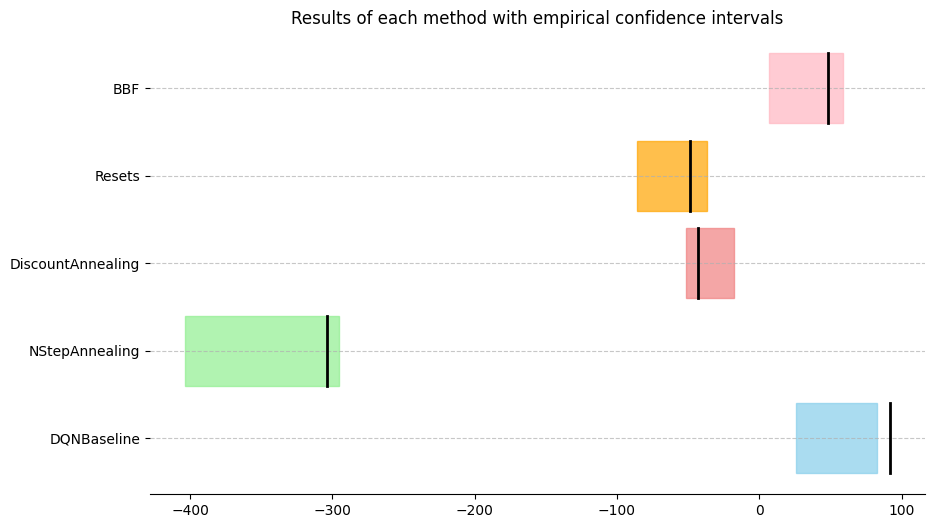

In [40]:
fig, ax = plot_results(aggregate_data(results_dict))
fig.show()